<a href="https://colab.research.google.com/github/fzlzjerry/MITGlobalCommodityFlow/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set Random Seed

import random
import numpy as np
import tensorflow as tf

random_seed = 42
random.seed(random_seed)  # set random seed for python
np.random.seed(random_seed)  # set random seed for numpy
tf.random.set_seed(random_seed)  # set random seed for tensorflow-cpu

# import

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import itertools

# Data

## Case Study

The primary objective is to construct a predictive model capable of forecasting the import weight of individual commodities within specific ports.

The data has the following variables:

* `COMM_PORT_ID`: A unique identifier for each commodity/port combination.                                  
* `Comm_ID`: A unique identifier for each commodity.                                         
* `Commodity`: Commodity description
* `Port_ID`: A unique identifier for each port
* `Port`: Port City, State
* `Time`: first day of the month for the aggregate imports.
* `Containerized Vessel SWT (Gen) (kg)`: Aggregate weight of all imports for the specific month/commodity/port combination
* `Customs Containerized Vessel Value (Gen) ($US)`: Aggregate value in dollars of all imports for the specific month/commodity/port combination
* `Coast`: categorical variable referencing the coast where the port is located (East or West)

## Load Data

In [ ]:
#import pandas as pd
df_ports = pd.read_csv('https://www.dropbox.com/scl/fi/a7gdrllxyfx5mdju4lyil/Port_level_Imports.csv?rlkey=0gc2y5avn4rhwch1ikp91rxv8&dl=1')


## Origin Data Exploration

In [ ]:
# display
df_ports

,COMM_PORT_ID,Comm_ID,Commodity,Port_ID,Port,Time,Containerized Vessel SWT (Gen) (kg),Customs Containerized Vessel Value (Gen) ($US),Coast
0,02_Bos,2,02 Meat And Edible Meat Offal,Bos,"Boston, MA (Port)",1/1/2003,41950,192600,East
1,02_Bos,2,02 Meat And Edible Meat Offal,Bos,"Boston, MA (Port)",3/1/2003,19686,99500,East
2,02_Bos,2,02 Meat And Edible Meat Offal,Bos,"Boston, MA (Port)",4/1/2003,20876,110200,East
3,02_Bos,2,02 Meat And Edible Meat Offal,Bos,"Boston, MA (Port)",5/1/2003,20975,92100,East
4,02_Bos,2,02 Meat And Edible Meat Offal,Bos,"Boston, MA (Port)",6/1/2003,19500,73020,East
...,...,...,...,...,...,...,...,...,...
36650,22_Sea,22,"22 Beverages, Spirits And Vinegar",Sea,"Seattle-Tacoma, WA (Port)",1/1/2024,7511539,23028122,West
36651,22_Sea,22,"22 Beverages, Spirits And Vinegar",Sea,"Seattle-Tacoma, WA (Port)",2/1/2024,6328009,13105366,West
36652,22_Sea,22,"22 Beverages, Spirits And Vinegar",Sea,"Seattle-Tacoma, WA (Port)",3/1/2024,8328816,18401969,West
36653,22_Sea,22,"22 Beverages, Spirits And Vinegar",Sea,"Seattle-Tacoma, WA (Port)",4/1/2024,7565666,17963557,West


In [ ]:
# display information about columns (non-null count and dtype)
df_ports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36655 entries, 0 to 36654
Data columns (total 9 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   COMM_PORT_ID                                    36655 non-null  object
 1   Comm_ID                                         36655 non-null  int64 
 2   Commodity                                       36655 non-null  object
 3   Port_ID                                         36655 non-null  object
 4   Port                                            36655 non-null  object
 5   Time                                            36655 non-null  object
 6   Containerized Vessel SWT (Gen) (kg)             36655 non-null  int64 
 7   Customs Containerized Vessel Value (Gen) ($US)  36655 non-null  int64 
 8   Coast                                           36655 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.5+ MB


In [ ]:
# explore descriptive statistics of the numerical data
df_ports.describe()

,Comm_ID,Containerized Vessel SWT (Gen) (kg),Customs Containerized Vessel Value (Gen) ($US)
count,36655.000000,3.665500e+04,3.665500e+04
mean,12.008348,1.034019e+07,2.569210e+07
std,6.052149,2.264354e+07,5.532470e+07
min,2.000000,4.700000e+01,2.083000e+03
25%,8.000000,8.152020e+05,1.785950e+06
50%,12.000000,3.027990e+06,6.509184e+06
75%,18.000000,1.013622e+07,2.414116e+07
max,22.000000,3.682924e+08,8.840858e+08


In [ ]:

df_ports.Port_ID.value_counts()

Port_ID
Hou    4112
Nor    4112
Oak    4112
Los    4112
New    4112
Sea    4110
Sav    4104
Cha    4069
Bos    3812
Name: count, dtype: int64

In [ ]:
df_ports.Commodity.value_counts()

Commodity
16 Prep Of Meat,of Fish,of Crustaceans Etc,of Insects    2313
17 Sugars And Sugar Confectionary                        2313
19 Prep Cereal, Flour, Starch Or Milk; Bakers Wares      2313
20 Prep Vegetables, Fruit, Nuts Or Other Plant Parts     2313
22 Beverages, Spirits And Vinegar                        2313
18 Cocoa And Cocoa Preparations                          2312
03 Fish, Crustaceans & Aquatic Invertebrates             2311
09 Coffee, Tea, Mate & Spices                            2311
10 Cereals                                               2308
11 Milling Products; Malt; Starch; Inulin; Wht Gluten    2308
07 Edible Vegetables & Certain Roots & Tubers            2305
12 Oil Seeds Etc.; Misc Grain, Seed, Fruit, Plant Etc    2295
13 Lac; Gums, Resins & Other Vegetable Sap & Extract     2291
08 Edible Fruit & Nuts; Citrus Fruit Or Melon Peel       2275
04 Dairy Prods; Birds Eggs; Honey; Ed Animal Pr Nesoi    2261
02 Meat And Edible Meat Offal                            211

In [ ]:
df_ports.Time.value_counts()

Time
3/1/2007     144
4/1/2009     144
12/1/2021    144
11/1/2009    144
10/1/2009    144
            ... 
2/1/2005     140
1/1/2011     140
8/1/2011     140
6/1/2010     140
7/1/2004     140
Name: count, Length: 257, dtype: int64

In [ ]:
df_ports.COMM_PORT_ID.value_counts()

COMM_PORT_ID
22_Sea    257
13_Los    257
17_Hou    257
17_Cha    257
17_Bos    257
         ... 
13_Bos    237
02_Cha    226
08_Bos    220
04_Bos    217
02_Bos     88
Name: count, Length: 144, dtype: int64

## Data Pre-process

In [ ]:
# shorten the name
df_ports.columns = df_ports.columns.str.replace("Containerized Vessel SWT (Gen) (kg)", "SWT")
df_ports.columns = df_ports.columns.str.replace("Customs Containerized Vessel Value (Gen) ($US)", "Value")

In [ ]:
df_ports_processed = df_ports.copy()

# format data
df_ports_processed['Time'] = pd.to_datetime(df_ports['Time'], format='%m/%d/%Y')
df_ports_processed = df_ports_processed.sort_values(by='Time')

In [ ]:
# data completion
key_cpid = df_ports_processed['COMM_PORT_ID'].unique()
key_time = df_ports_processed['Time'].unique()

all_combinations = pd.DataFrame(list(itertools.product(key_cpid, key_time)), columns=['COMM_PORT_ID', 'Time'])

# Merge with the original DataFrame
df_complete = pd.merge(all_combinations, df_ports_processed, on=['COMM_PORT_ID', 'Time'], how='left')

# Calculate Comm_ID, Port_ID from COMM_PORT_ID
df_complete['Comm_ID'] = df_complete['COMM_PORT_ID'].str.split('_').str[0]
df_complete['Port_ID'] = df_complete['COMM_PORT_ID'].str.split('_').str[1]

# Fill missing values with 0
df_complete['SWT'] = df_complete['SWT'].fillna(0)
df_complete['Value'] = df_complete['Value'].fillna(0)

# Sort
df_complete = df_complete.set_index('Time')
df_complete.sort_values(by=['Time'], inplace=True)
df_complete = df_complete.reset_index()

# delete useless description column
df_filted = df_complete.filter(items=['Time', 'COMM_PORT_ID' ,'Comm_ID', 'Port_ID', 'SWT', 'Value', 'Coast'])

df_filted

,Time,COMM_PORT_ID,Comm_ID,Port_ID,SWT,Value,Coast
0,2003-01-01,02_Bos,02,Bos,41950.0,192600.0,East
1,2003-01-01,07_Sav,07,Sav,649043.0,325197.0,East
2,2003-01-01,17_Nor,17,Nor,730580.0,1582809.0,East
3,2003-01-01,19_Los,19,Los,9105453.0,13076558.0,West
4,2003-01-01,17_Los,17,Los,1604736.0,3737368.0,West
...,...,...,...,...,...,...,...
37003,2024-05-01,22_Cha,22,Cha,8630486.0,23869750.0,East
37004,2024-05-01,13_Oak,13,Oak,44532.0,1132212.0,West
37005,2024-05-01,20_Hou,20,Hou,18892778.0,29756797.0,East
37006,2024-05-01,13_Sav,13,Sav,199162.0,1180612.0,East


We should convert `Comm_ID` and `Port_ID` into one-hot vectors.

Since `Comm_ID=1` and `Comm_ID=2` is totally different things.

In [ ]:
# Convert COMM_ID, PORT_ID to one-hot vectors
df_onehot = pd.get_dummies(df_filted, columns=['Comm_ID', 'Port_ID', 'Coast'])
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37008 entries, 0 to 37007
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Time          37008 non-null  datetime64[ns]
 1   COMM_PORT_ID  37008 non-null  object        
 2   SWT           37008 non-null  float64       
 3   Value         37008 non-null  float64       
 4   Comm_ID_02    37008 non-null  bool          
 5   Comm_ID_03    37008 non-null  bool          
 6   Comm_ID_04    37008 non-null  bool          
 7   Comm_ID_07    37008 non-null  bool          
 8   Comm_ID_08    37008 non-null  bool          
 9   Comm_ID_09    37008 non-null  bool          
 10  Comm_ID_10    37008 non-null  bool          
 11  Comm_ID_11    37008 non-null  bool          
 12  Comm_ID_12    37008 non-null  bool          
 13  Comm_ID_13    37008 non-null  bool          
 14  Comm_ID_16    37008 non-null  bool          
 15  Comm_ID_17    37008 non-null  bool  

## Processed Data Exploration

### Show by *Port*

In [ ]:
port_ID = 'Bos'

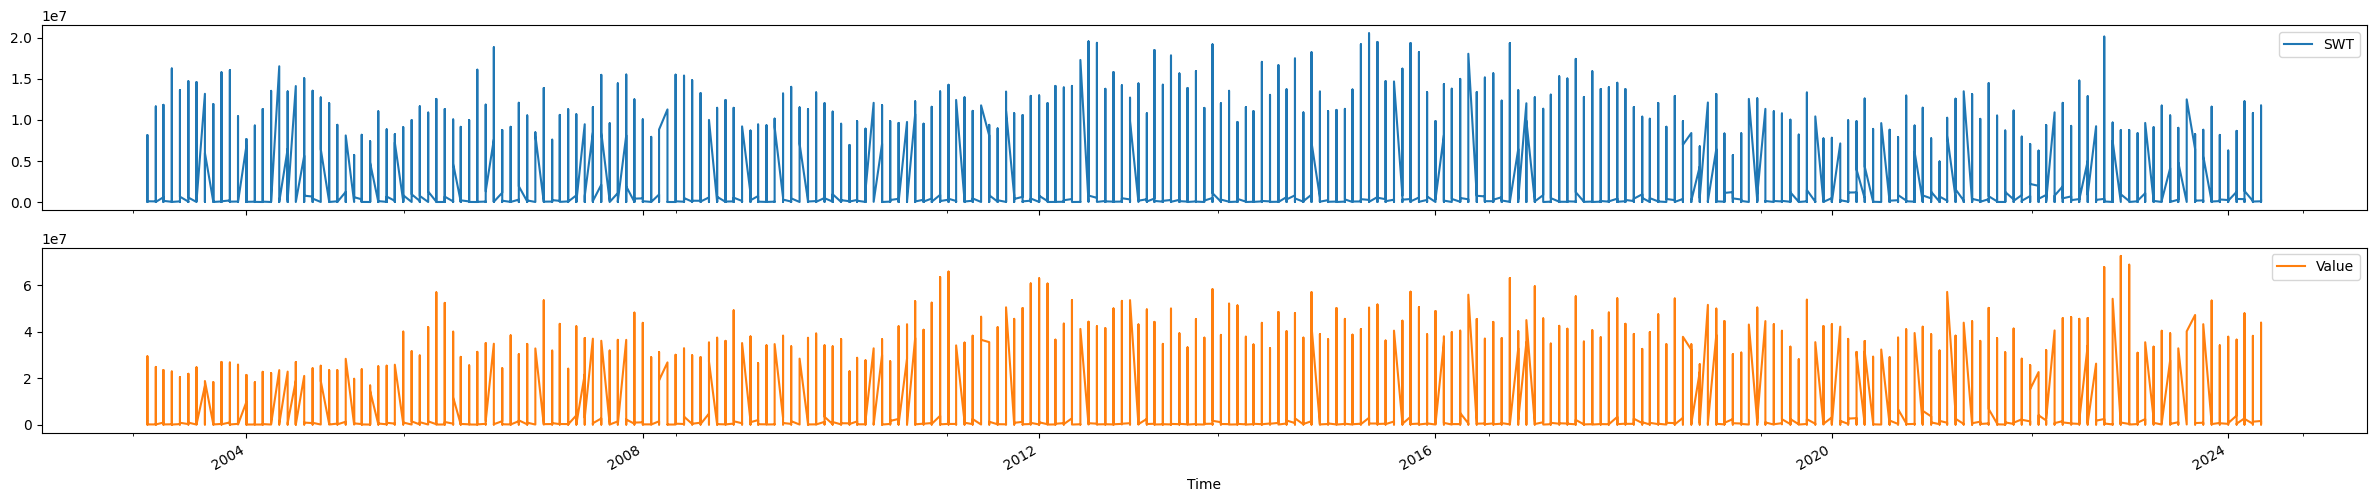

In [ ]:
import datetime

t_start = datetime.datetime(2021, 1, 1)
t_end = datetime.datetime(2021, 12, 31)

df_p = df_filted.query('Port_ID == @port_ID')

# show line plot
df_p.plot(x='Time', y=['SWT', 'Value'], subplots=True, kind='line', figsize=(30, 6))
plt.show()


### Show by *Port & Commodity*

In [ ]:
comm_port_id = "03_Bos"

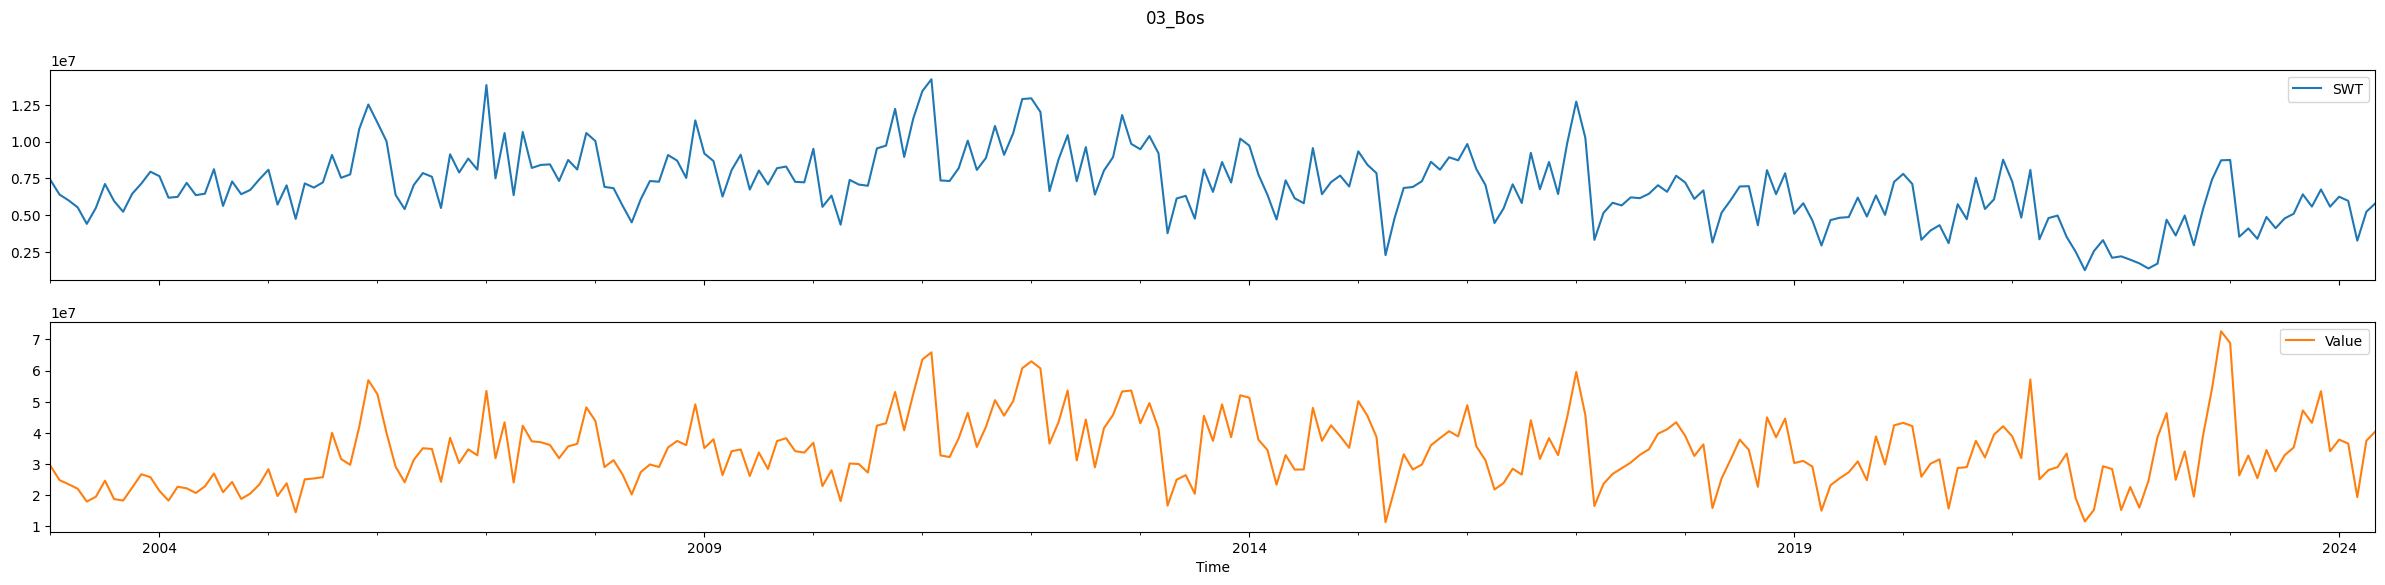

In [ ]:
df_pc = df_filted.query('COMM_PORT_ID == @comm_port_id')

# show line plot
df_pc.plot(x='Time', y=['SWT', 'Value'], subplots=True, kind='line', figsize=(30, 6))
plt.suptitle(comm_port_id)
plt.show()

# Simple DNN

## 1: use date & value [failed]

### data fields
#### x
- week day (1-7)
- month (1-12)
- year
- Value
#### y
- SWT


In [ ]:
input_shape = [4]

In [ ]:
df_reshaped = df_pc.copy()

df_reshaped['day'] = df_reshaped['Time'].dt.isocalendar().day
df_reshaped['month'] = df_reshaped['Time'].dt.month
df_reshaped['year'] = df_reshaped['Time'].dt.year
df_reshaped['value'] = df_reshaped['Value']
df_reshaped['swt'] = df_reshaped['SWT']

df_reshaped = df_reshaped[['day', 'month', 'year', 'value', 'swt']]

df_reshaped

,day,month,year,value,swt
62,3,1,2003,29386199.0,7387051.0
213,6,2,2003,24814505.0,6398093.0
337,6,3,2003,23494666.0,6005138.0
472,2,4,2003,22048828.0,5525019.0
708,4,5,2003,17935701.0,4406969.0
...,...,...,...,...,...
36344,1,1,2024,37829243.0,6253391.0
36448,4,2,2024,36561702.0,5973270.0
36626,5,3,2024,19369229.0,3263138.0
36776,1,4,2024,37485082.0,5232901.0


### structure

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [ ]:
model.compile(
    loss='mae',
    optimizer='adam'
)

### Train

In [ ]:
x_train, x_test = train_test_split(df_reshaped, test_size=0.3, shuffle=False)
y_train = x_train.pop('swt')
y_test = x_test.pop('swt')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    patience=7, # number of epochs to wait
    min_delta=0.001, # minimun change in loss function
    restore_best_weights=True # restore the weights with the best loss
)

Epoch 1/50
18/18 [==============================] - 1s 10ms/step - loss: 1599943.8750 - val_loss: 1530076.8750
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 907947.6250 - val_loss: 1758187.2500
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 905413.1250 - val_loss: 1998272.8750
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 887609.3750 - val_loss: 2100040.0000
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 828769.4375 - val_loss: 2076294.6250
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 827879.6250 - val_loss: 2273210.7500
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 812240.3750 - val_loss: 2475201.7500
Epoch 8/50
18/18 [==============================] - 0s 3ms/step - loss: 828623.6250 - val_loss: 2502065.2500
Minimum Validation Loss: 1530076.8750


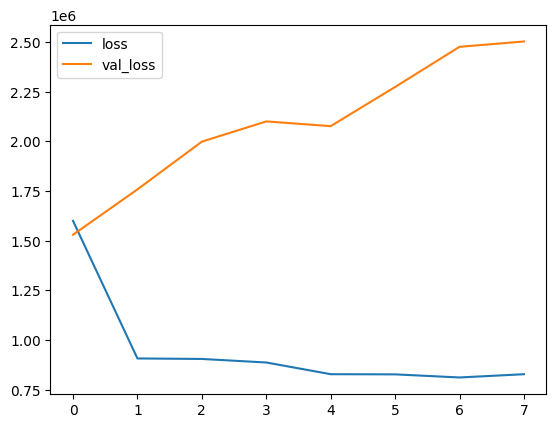

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [ ]:
input_shape = [4]

In [ ]:
df_reshaped = df_pc.copy()

df_reshaped['day'] = df_reshaped['Time'].dt.isocalendar().day
df_reshaped['month'] = df_reshaped['Time'].dt.month
df_reshaped['year'] = df_reshaped['Time'].dt.year
df_reshaped['value'] = df_reshaped['Value']
df_reshaped['swt'] = df_reshaped['SWT']

df_reshaped = df_reshaped[['day', 'month', 'year', 'value', 'swt']]

df_reshaped

,day,month,year,value,swt
62,3,1,2003,29386199.0,7387051.0
213,6,2,2003,24814505.0,6398093.0
337,6,3,2003,23494666.0,6005138.0
472,2,4,2003,22048828.0,5525019.0
708,4,5,2003,17935701.0,4406969.0
...,...,...,...,...,...
36344,1,1,2024,37829243.0,6253391.0
36448,4,2,2024,36561702.0,5973270.0
36626,5,3,2024,19369229.0,3263138.0
36776,1,4,2024,37485082.0,5232901.0


## 2: use date only [overfitting]

### data fields
#### x
- week day (1-7)
- month (1-12)
- year

#### y
- SWT

In [ ]:
input_shape = [3]

In [ ]:
df_reshaped = df_pc.copy()

df_reshaped['day'] = df_reshaped['Time'].dt.isocalendar().day
df_reshaped['month'] = df_reshaped['Time'].dt.month
df_reshaped['year'] = df_reshaped['Time'].dt.year
df_reshaped['swt'] = df_reshaped['SWT']

df_reshaped = df_reshaped[['day', 'month', 'year', 'swt']]

df_reshaped

,day,month,year,swt
62,3,1,2003,7387051.0
213,6,2,2003,6398093.0
337,6,3,2003,6005138.0
472,2,4,2003,5525019.0
708,4,5,2003,4406969.0
...,...,...,...,...
36344,1,1,2024,6253391.0
36448,4,2,2024,5973270.0
36626,5,3,2024,3263138.0
36776,1,4,2024,5232901.0


### structure

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# model-1: origin
# model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=input_shape),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1)
# ])

# model-2: dropout
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [ ]:
model.compile(
    loss='mae',
    optimizer='adam'
)

### Train

In [ ]:
x_train, x_test = train_test_split(df_reshaped, test_size=0.3, shuffle=False)
y_train = x_train.pop('swt')
y_test = x_test.pop('swt')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    patience=7, # number of epochs to wait
    min_delta=0.001, # minimun change in loss function
    restore_best_weights=True # restore the weights with the best loss
)

Epoch 1/50
18/18 [==============================] - 1s 9ms/step - loss: 7840954.5000 - val_loss: 5098524.5000
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 7838695.0000 - val_loss: 5094563.5000
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 7831758.0000 - val_loss: 5082986.5000
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 7813045.0000 - val_loss: 5053914.5000
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 7767001.5000 - val_loss: 4990986.0000
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 7687710.0000 - val_loss: 4875210.0000
Epoch 7/50
18/18 [==============================] - 0s 21ms/step - loss: 7527919.5000 - val_loss: 4670715.0000
Epoch 8/50
18/18 [==============================] - 0s 3ms/step - loss: 7265146.5000 - val_loss: 4335393.5000
Epoch 9/50
18/18 [==============================] - 0s 3ms/step - loss: 6852882.5000 - val_loss: 3821465.7500
Epoch 10/

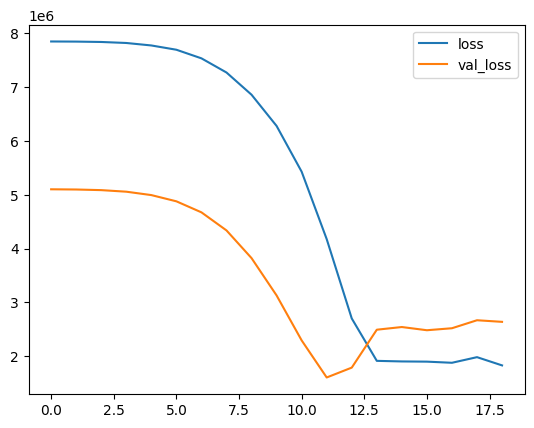

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

## 3: use date only, without year [best result]

In [ ]:
# Set Random Seed

import random
import numpy as np
import tensorflow as tf

random_seed = 42
random.seed(random_seed)  # set random seed for python
np.random.seed(random_seed)  # set random seed for numpy
tf.random.set_seed(random_seed)  # set random seed for tensorflow-cpu

### data fields
#### x
- week day (1-7)
- month (1-12)
- year

#### y
- SWT

In [ ]:
input_shape = [2]

In [ ]:
df_reshaped = df_pc.copy()

df_reshaped['day'] = df_reshaped['Time'].dt.isocalendar().day
df_reshaped['month'] = df_reshaped['Time'].dt.month
df_reshaped['swt'] = df_reshaped['SWT']

df_reshaped = df_reshaped[['day', 'month', 'swt']]

df_reshaped

,day,month,swt
62,3,1,7387051.0
213,6,2,6398093.0
337,6,3,6005138.0
472,2,4,5525019.0
708,4,5,4406969.0
...,...,...,...
36344,1,1,6253391.0
36448,4,2,5973270.0
36626,5,3,3263138.0
36776,1,4,5232901.0


### structure

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# model-1: origin
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [ ]:
model.compile(
    loss='mae',
    optimizer='adam'
)

### Train

In [ ]:
x_train, x_test = train_test_split(df_reshaped, test_size=0.3, shuffle=False)
y_train = x_train.pop('swt')
y_test = x_test.pop('swt')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    patience=7, # number of epochs to wait
    min_delta=1000, # minimun change in loss function
    restore_best_weights=True # restore the weights with the best loss
)

Epoch 1/50
18/18 [==============================] - 1s 8ms/step - loss: 7841812.5000 - val_loss: 5100049.0000
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 7841804.0000 - val_loss: 5100034.0000
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 7841777.0000 - val_loss: 5099991.0000
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 7841706.0000 - val_loss: 5099881.5000
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 7841538.0000 - val_loss: 5099637.5000
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 7841185.0000 - val_loss: 5099148.5000
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 7840510.0000 - val_loss: 5098269.5000
Epoch 8/50
18/18 [==============================] - 0s 3ms/step - loss: 7839360.0000 - val_loss: 5096801.0000
Epoch 9/50
18/18 [==============================] - 0s 2ms/step - loss: 7837489.5000 - val_loss: 5094515.5000
Epoch 10/5

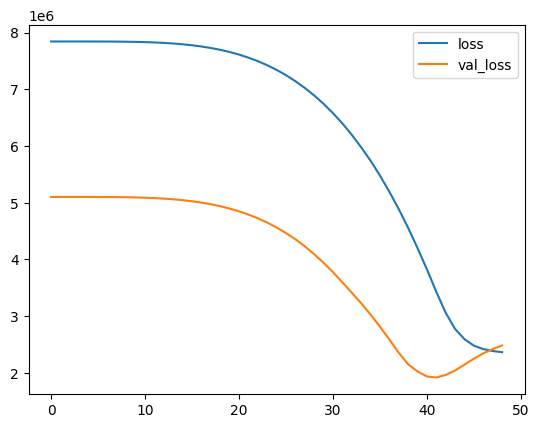

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [ ]:
# Set Random Seed

import random
import numpy as np
import tensorflow as tf

random_seed = 42
random.seed(random_seed)  # set random seed for python
np.random.seed(random_seed)  # set random seed for numpy
tf.random.set_seed(random_seed)  # set random seed for tensorflow-cpu

### data fields
#### x
- week day (1-7)
- month (1-12)
- year

#### y
- SWT

In [ ]:
input_shape = [3]

In [ ]:
df_reshaped = df_pc.copy()

df_reshaped['day'] = df_reshaped['Time'].dt.isocalendar().day
df_reshaped['month'] = df_reshaped['Time'].dt.month
df_reshaped['year'] = df_reshaped['Time'].dt.year
df_reshaped['swt'] = df_reshaped['SWT']

df_reshaped = df_reshaped[['day', 'month', 'year', 'swt']]

df_reshaped

,day,month,year,swt
62,3,1,2003,7387051.0
213,6,2,2003,6398093.0
337,6,3,2003,6005138.0
472,2,4,2003,5525019.0
708,4,5,2003,4406969.0
...,...,...,...,...
36344,1,1,2024,6253391.0
36448,4,2,2024,5973270.0
36626,5,3,2024,3263138.0
36776,1,4,2024,5232901.0


### structure

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# model-1: origin
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [ ]:
model.compile(
    loss='mae',
    optimizer='adam'
)

### Train

In [ ]:
x_train, x_test = train_test_split(df_reshaped, test_size=0.3, shuffle=False)
y_train = x_train.pop('swt')
y_test = x_test.pop('swt')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    patience=7, # number of epochs to wait
    min_delta=1000, # minimun change in loss function
    restore_best_weights=True # restore the weights with the best loss
)

Epoch 1/50
18/18 [==============================] - 1s 9ms/step - loss: 7841813.5000 - val_loss: 5098854.5000
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 7841810.0000 - val_loss: 5097475.5000
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 7841800.0000 - val_loss: 5094826.5000
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 7841777.0000 - val_loss: 5089820.5000
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 7841728.5000 - val_loss: 5080366.0000
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 7841633.5000 - val_loss: 5064690.5000
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 7841468.0000 - val_loss: 5036190.0000
Epoch 8/50
18/18 [==============================] - 0s 3ms/step - loss: 7841180.0000 - val_loss: 4995016.0000
Epoch 9/50
18/18 [==============================] - 0s 3ms/step - loss: 7840729.5000 - val_loss: 4948174.0000
Epoch 10/5

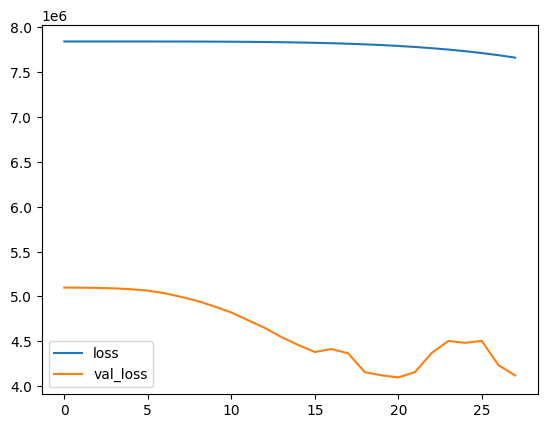

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# RNN

In [ ]:
# check if there are gpu
tf.config.list_physical_devices('GPU')

[]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Conv1D, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
import keras_tuner as kt
import os
import joblib

# 以上代码导入了数据处理、机器学习和深度学习所需的库。包括pandas、numpy、scikit-learn进行数据预处理，
# TensorFlow和Keras进行模型构建与训练，keras-tuner进行超参数调优。

In [ ]:
# 设置序列长度
seq_length = 12  # 示例序列长度

# 这里定义了用于训练模型的时间序列长度。

In [ ]:
# 加载数据
file_path = 'Port_level_Imports_Filled_All.csv'
data = pd.read_csv(file_path)

# 将时间列转换为日期时间格式
data['Time'] = pd.to_datetime(data['Time'])

# 按港口、商品和时间排序数据
data = data.sort_values(by=['Port', 'Commodity', 'Time'])

# 将重量和价值列转换为数值
data['SWT'] = data['SWT'].astype(float)
data['Value'] = data['Value'].astype(float)

# 以上代码加载CSV文件的数据，将时间列转换为日期时间格式，并按港口、商品和时间排序。

In [ ]:
# 添加时间特征
data['Month'] = data['Time'].dt.month
data['Quarter'] = data['Time'].dt.quarter
data['Year'] = data['Time'].dt.year
data['DayOfWeek'] = data['Time'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'] >= 5

# 这段代码根据时间列添加一些额外的时间特征，如月份、季度、年份、星期几，以及是否是周末。

In [ ]:
# 对类别型特征进行编码
port_encoder = LabelEncoder()
commodity_encoder = LabelEncoder()
data['Port_encoded'] = port_encoder.fit_transform(data['Port'])
data['Commodity_encoded'] = commodity_encoder.fit_transform(data['Commodity'])

# 这段代码将港口和商品的类别特征转换为数值编码，以便模型能够处理。

In [ ]:
# 确保所有需要的特征都在这里
features = ['SWT', 'Month', 'Quarter', 'Year', 'DayOfWeek', 'IsWeekend', 'Value', 'Port_encoded', 'Commodity_encoded']

# 选择用于训练模型的特征。

In [ ]:
# 定义创建序列的函数
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length][0]  # 假设目标是SWT，确保目标值是标量
        xs.append(x)
        ys.append(y)
    if not xs or not ys:
        raise ValueError("No sequences were created. Check the length of the data and seq_length.")
    return np.array(xs), np.array(ys)

# 将数据分割成用于时间序列模型的输入输出序列。

In [ ]:
# 定义超参数调优模型
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        input_layer = Input(shape=(seq_length, len(features)))

        x = input_layer
        for i in range(10):  # 卷积层数
            kernel_size = hp.Int(f'kernel_size_conv_{i}', min_value=2, max_value=5, step=1)
            if seq_length - kernel_size < 1:
                kernel_size = 2  # 确保卷积核大小不超过输入数据时间步长

            x = Conv1D(filters=hp.Int(f'filters_conv_{i}', min_value=32, max_value=256, step=32),
                       kernel_size=kernel_size,
                       padding='same', activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(rate=hp.Float(f'dropout_conv_{i}', min_value=0.2, max_value=0.5, step=0.1))(x)

        for i in range(10):  # LSTM层数
            lstm_layer = LSTM(units=hp.Int(f'units_lstm_{i}', min_value=128, max_value=512, step=64),
                              return_sequences=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
            lstm_layer = Dense(x.shape[-1], activation='linear')(lstm_layer)
            x = Add()([x, lstm_layer])
            x = BatchNormalization()(x)
            x = Dropout(rate=hp.Float(f'dropout_lstm_{i}', min_value=0.2, max_value=0.5, step=0.1))(x)

        for i in range(10):  # GRU层数
            gru_layer = GRU(units=hp.Int(f'units_gru_{i}', min_value=128, max_value=512, step=64),
                            return_sequences=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
            gru_layer = Dense(x.shape[-1], activation='linear')(gru_layer)
            x = Add()([x, gru_layer])
            x = BatchNormalization()(x)
            x = Dropout(rate=hp.Float(f'dropout_gru_{i}', min_value=0.2, max_value=0.5, step=0.1))(x)

        multi_head_attention_layer = MultiHeadAttention(num_heads=8, key_dim=hp.Int('key_dim_attention', min_value=128,
                                                                                    max_value=512, step=64))(x, x)
        x = Add()([x, multi_head_attention_layer])
        x = LayerNormalization()(x)
        x = Dropout(rate=hp.Float('dropout_attention', min_value=0.2, max_value=0.5, step=0.1))(x)

        for i in range(10):  # 全连接层数
            dense_layer = Dense(units=hp.Int(f'units_dense_{i}', min_value=128, max_value=512, step=64),
                                activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
            x = Dropout(rate=hp.Float(f'dropout_dense_{i}', min_value=0.2, max_value=0.5, step=0.1))(dense_layer)

        output_layer = Dense(1)(x)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=hp.Choice('optimizer', ['adam', 'adamax', 'nadam']), loss='mse')
        return model

    def get_config(self):
        return {}

    def build_from_config(self, config):
        return self.build(config)

# 这段代码定义了一个超参数调优模型，其中包含卷积层、LSTM层、GRU层和多头注意力层，并添加了残差连接和归一化层。

In [ ]:
# 启用混合精度训练
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 启用混合精度训练以加快训练速度并减少内存占用。

In [ ]:
# 设置超参数调整器
tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_loss',
    max_epochs=200,
    factor=3,
    directory='my_dir',
    project_name='commodity_forecasting'
)

# 使用Hyperband调优器进行超参数搜索。

In [ ]:
# 设置批处理大小和回调函数
batch_size = 512
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
]

# 定义了一些回调函数以帮助优化模型训练过程，包括早停、学习率调整和模型检查点。

In [ ]:
# 创建存储模型的目录
if not os.path.exists('models'):
    os.makedirs('models')

# 创建存储训练好的模型的目录。

In [ ]:
# 遍历每个港口和商品组合
for port in ports:
    for commodity in commodities:
        # 筛选选定港口和商品的数据
        subset = data[(data['Port'] == port) & (data['Commodity'] == commodity)]

        # 检查样本数量是否足够
        if len(subset) < seq_length:
            print(f"Skipping {port} - {commodity} due to insufficient data")
            continue

        # 规范化数据
        scaler = MinMaxScaler()
        subset_scaled = scaler.fit_transform(subset[features])

        # 创建序列
        try:
            X, y = create_sequences(subset_scaled, seq_length)
        except ValueError as ve:
            print(f"Error creating sequences for {port} - {commodity}: {ve}")
            continue

        # 将数据分为训练和测试集
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        print(f"Training model for {port} - {commodity}")

        try:
            # 打印形状以确保匹配
            print(f"Shape of X_train: {X_train.shape}")
            print(f"Shape of y_train: {y_train.shape}")

            # 进行超参数搜索
            tuner.search(X_train, y_train, epochs=200, validation_split=0.2, callbacks=callbacks, batch_size=batch_size)

            # 获取最佳模型
            best_model = tuner.get_best_models(num_models=1)[0]

            # 在测试集上评估最佳模型
            test_loss = best_model.evaluate(X_test, y_test)
            print(f"Test loss for {port} - {commodity}: {test_loss}")

            # 保存最佳模型
            best_model.save(f"models/best_model_{port}_{commodity}.h5")

        except Exception as e:
            print(f"Error training model for {port} - {commodity}: {e}")

# 对每个港口和商品组合进行数据筛选和预处理，然后创建序列，分割训练和测试集，进行超参数搜索，最后保存最佳模型。